#Libraries and Folders

In [3]:
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
print(torch.cuda.get_device_name(0))

Tesla T4


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
PATH = "/content/drive/MyDrive/ComplexSystemsProject/"

#Dataset

In [6]:
data = pd.read_csv(PATH + "pima-indians-diabetes.csv",header = None, names =["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age","Outcome"])

In [7]:
traindata = data.sample(frac = 0.8 , random_state=1)
testdata =data.drop(traindata.index)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


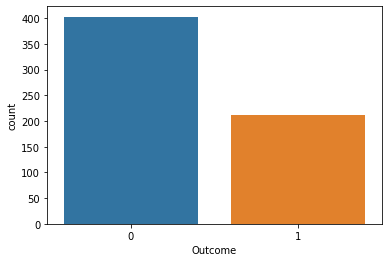

In [8]:
sns.countplot(traindata["Outcome"])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


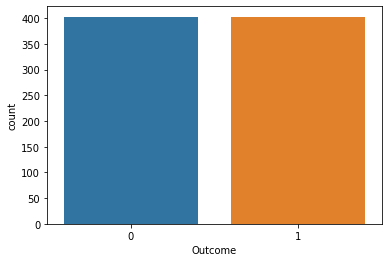

In [9]:
class0 = traindata[traindata["Outcome"]==0]
class1 = traindata[traindata["Outcome"]==1]
class1_over = class1.sample(len(class0), replace = True, random_state = 2)

balanced_traindata = pd.concat([class0, class1_over])
balanced_traindata = balanced_traindata.sample(frac = 1).reset_index(drop=True)
sns.countplot(balanced_traindata["Outcome"])

In [10]:
class pima_dataset(Dataset):

    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        input = torch.tensor(self.data.iloc[idx, :8], dtype = torch.float)
        label = int(self.data.iloc[idx,8])
        return input, label

In [11]:
trainset = pima_dataset(balanced_traindata)
testset = pima_dataset(testdata)

#Model

In [12]:
class modelA (nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(8,6)
        self.hidden2 = nn.Linear(6,4)
        self.hidden3 = nn.Linear(4,4)
        self.out = nn.Linear(4,2)
        
    def forward(self,x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.out(x)
        return x



class modelB(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(8, 10)
        self.out = nn.Linear(10,2)
        
    def forward(self,x):
        x = F.relu(self.hidden1(x))
        x = self.out(x)
        return x

In [13]:
net = None 
total_params = None

model = "modelA"
if (model == "modelA"):
    net = modelA()
    total_params = 112

    
if torch.cuda.is_available():
    net.cuda()
else:
    print ("NO CUDA!")

In [14]:
from torchsummary import summary
summary(net, (8,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 6]              54
            Linear-2                    [-1, 4]              28
            Linear-3                    [-1, 4]              20
            Linear-4                    [-1, 2]              10
Total params: 112
Trainable params: 112
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


#Functions

In [15]:
def compute_loss():
    with torch.no_grad():
        x = torch.tensor(trainset.data.drop("Outcome", axis=1).values, dtype = torch.float)
        y = torch.tensor(trainset.data["Outcome"].values)
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        outputs = net(x)
        loss = loss_function(outputs, y)
    return loss.item()

In [16]:
def validate():
    accuracy = None
    val_loss = None
    net.eval()
    with torch.no_grad():
        x = torch.tensor(testset.data.drop("Outcome", axis=1).values, dtype = torch.float)
        y = torch.tensor(testset.data["Outcome"].values)
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        outputs = net(x)
        results = (y == outputs.argmax(dim=1))
        accuracy = (results.sum().item())/results.numel()
        val_loss = loss_function(outputs, y)
    net.train()
    return accuracy, val_loss.item()

In [17]:
def get_state():
    perlayer = []
    with torch.no_grad():
        for x in net.parameters():
            perlayer.append(x.flatten().cpu().numpy())
    return np.concatenate(perlayer)

#Training and Data Acquisition

In [18]:
batch_size = 16
lr = 0.001

trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 6)
optimizer = torch.optim.SGD(net.parameters(),lr=lr, weight_decay = 4e-3)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [500])
loss_function = nn.CrossEntropyLoss()

In [ ]:
n = 61
for j in range(20):
    train_data = np.empty((0,total_params+1))
    test_data = np.empty((0, 2))

    train_stream = open(PATH + model + "/DATA/train_data_" + str(n+j) +".txt", 'a')
    test_stream = open(PATH+ model + "/DATA/test_data_"+ str(n+j)+ ".txt", 'a')
    fmt1 = ['%1.7f' for i in range(total_params+1)]
    fmt2 = ['%1.3f', '%1.7f']

    epochs = 1000

    old_state = torch.load(PATH + model + "/SAVED_STATES/save_"+ str(n+j-1))
    net.load_state_dict(old_state)

    for step in tqdm(range(epochs)):

        accuracy, val_loss = validate()
        test_data = np.append(test_data, np.array([accuracy, val_loss]).reshape((1, 2)), axis = 0)

        #Start a new epoch
        for i, data in enumerate(trainloader):


            #Save epoch number, state, loss
            state = get_state()
            true_loss = compute_loss()
            train_data = np.append(train_data, np.concatenate([state, np.array([true_loss,])]).reshape((1,total_params+1)), axis=0)


            #Make a step
            net.train()
            inputs, labels = data
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = net(inputs)
            optimizer.zero_grad()
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

        #scheduler.step()

        if  step%100==99: 
            #Save data to file
            np.savetxt(train_stream, train_data, fmt =fmt1)
            train_stream.flush()
            train_data = np.empty((0,total_params+1))

            np.savetxt(test_stream ,test_data, fmt = fmt2 )
            test_stream.flush()
            test_data = np.empty((0, 2))

    torch.save(net.state_dict(), PATH + model + "/SAVED_STATES/save_"+ str(n+j)) 

  8%|▊         | 79/1000 [00:56<11:15,  1.36it/s]